# Machine Learing_Part 2

In this part, we are trying to address the issue of imbalanced data.
The strategies includes undersampling and oversampling(SMOTE) and hyperparameter tuning (for balance) in algorithms.
We will also change the cutoff value in the evalution matrix as a trade off to achieve the desired target. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from itertools import cycle

In [87]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import (roc_auc_score,accuracy_score, classification_report,
confusion_matrix,recall_score,precision_recall_curve,auc,roc_curve)
from sklearn.model_selection import train_test_split,GridSearchCV
import tensorflow as tf
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

### 1.Preparing the traing/test data

In [12]:
train = pd.read_csv('~/Desktop/train.csv')
test =  pd.read_csv('~/Desktop/test.csv')

In [14]:
y_train = train['Response']
X_train = train.loc[:, train.columns !='Response']

In [17]:
y_test = test['Response']
X_test = test.loc[:, test.columns !='Response']
y_test_repay = y_test.value_counts()[0]
y_test_default = y_test.value_counts()[1]

### 2.Preparing undersampling training data 

In [50]:
# Number of data points in the minority class
number_default = len(train[train.Response == 1])
default_indices = np.array(train[train.Response == 1].index)

# Picking the indices of the repay classes
repay_indices = np.array(train[train.Response == 0].index)

# Out of the indices we picked, randomly select "x" number (number_default)
random_repay_indices = np.random.choice(repay_indices, number_default, replace = False)
random_repay_indices = np.array(random_repay_indices)

under_sample_indices = np.concatenate([default_indices,random_repay_indices])

# Under sample dataset
under_sample_data = train.iloc[under_sample_indices,:]

us_X_train = under_sample_data.loc[:, under_sample_data.columns != 'Response']
us_y_train = under_sample_data.loc[:, under_sample_data.columns == 'Response']

In [66]:
np.array(us_y_train).shape

(112, 1)

### 3.Preparing oversampling training data

In [56]:
# To deal with the imbalanced data, we use SMOTE for oversampling
os = SMOTE(random_state=1) 
os_X_train,os_y_train=os.fit_sample(X_train,y_train)

In [67]:
os_y_train.shape

(3914,)

### 4.Train the models by cross validation

In [76]:
def cv_train_model (model, X_train, y_train, cv_folder):
    X_train = np.array (X_train)
    y_train = np.array (y_train).ravel()
    kfolder=StratifiedKFold(y_train, n_folds= cv_folder, shuffle=True, random_state=1)
    grand_auc =0.0
    i = 0
    grand_accuracy =0.0
    for train_index, test_index in kfolder:
        X_trained, X_cv = X_train[train_index], X_train[test_index]
        y_trained, y_cv = y_train[train_index], y_train[test_index]
        model.fit(X_trained, y_trained)
        preds = model.predict_proba(X_cv)[:,1]
        pred = model.predict(X_cv)
        auc=roc_auc_score(y_cv,preds)
        accuracy=accuracy_score(y_cv, pred)
        #print('fold %d/%d auc %f' %(i+1,cv_folder,auc))
        #print('fold %d/%d accuracy %f' %(i+1,cv_folder,accuracy))
        grand_auc +=auc
        grand_accuracy +=accuracy
        i +=1
    
    grand_auc /= cv_folder
    print('grand AUC is %f' %(grand_auc))
    grand_accuracy /=cv_folder
    print('grand accuracy is %f' %(grand_accuracy))

In [88]:
models = (
          ('Random Forest',RandomForestClassifier()), 
          ('Logistic Regression',LogisticRegression()),
          ('Gradient Booosting',XGBClassifier()),
          ('K-nearest neighbour',KNeighborsClassifier())
)

#### 4.1 Without sampling

In [89]:
for name, model in models:
    print (name,':')
    cv_train_model (model, X_train, y_train, 4)
    print ()

Random Forest :
grand AUC is 0.567206
grand accuracy is 0.972181

Logistic Regression :
grand AUC is 0.608185
grand accuracy is 0.972678

Gradient Booosting :
grand AUC is 0.635041
grand accuracy is 0.972181

K-nearest neighbour :
grand AUC is 0.486633
grand accuracy is 0.972181



#### 4.2 Oversamling 

In [90]:
for name, model in models:
    print (name,':')
    cv_train_model (model, os_X_train, os_y_train, 4)
    print ()

Random Forest :
grand AUC is 0.995681
grand accuracy is 0.972150

Logistic Regression :
grand AUC is 0.768425
grand accuracy is 0.701841

Gradient Booosting :
grand AUC is 0.990406
grand accuracy is 0.948644

K-nearest neighbour :
grand AUC is 0.917277
grand accuracy is 0.828310



#### 4.3 Undersampling

In [91]:
for name, model in models:
    print (name,':')
    cv_train_model (model, us_X_train, us_y_train, 4)
    print ()

Random Forest :
grand AUC is 0.624362
grand accuracy is 0.607143

Logistic Regression :
grand AUC is 0.571429
grand accuracy is 0.598214

Gradient Booosting :
grand AUC is 0.650510
grand accuracy is 0.562500

K-nearest neighbour :
grand AUC is 0.587372
grand accuracy is 0.571429



### 5.Evaluation report and plot

In [108]:
def predict_evaluation(model, X_train, y_train, X_test, y_test):
    
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test) 
     
    
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    preds = model.predict_proba(X_test)[:,1]
    
    PlotConfusionMatrix(y_test,pred)
    PlotCurves(y_test,preds)

In [153]:
def PlotConfusionMatrix(y_test,pred):
    
    sns.set(style="white")
    cfn_matrix = confusion_matrix(y_test,pred)
    
    y_test_repay = y_test.value_counts()[0]
    y_test_default = y_test.value_counts()[1]
    cfn_norm_matrix = np.array([[1.0 / y_test_repay,1.0/y_test_repay],[1.0/y_test_default,1.0/y_test_default]])
    norm_cfn_matrix = cfn_matrix * cfn_norm_matrix

    fig = plt.figure(figsize=(8,3))
    ax = fig.add_subplot(1,2,1)
    sns.heatmap(cfn_matrix,cmap='coolwarm_r',linewidths=0.5,annot=True,ax=ax)
    plt.title('Confusion Matrix')
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')

    ax = fig.add_subplot(1,2,2)
    sns.heatmap(norm_cfn_matrix,cmap='coolwarm_r',linewidths=0.5,annot=True,ax=ax)

    plt.title('Normalized Confusion Matrix')
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')
    plt.show()
    
    print('---Classification Report---')
    print(classification_report(y_test,pred))

In [150]:
def PlotCurves(y_test,preds):
    
    sns.set(style="white")
    fig = plt.figure(figsize=(8,4))
    ax1 = fig.add_subplot(1,2,1)
    ax1.set_xlim([-0.05,1.05])
    ax1.set_ylim([-0.05,1.05])
    ax1.set_xlabel('Recall')
    ax1.set_ylabel('Precision')
    ax1.set_title('PR Curve')

    ax2 = fig.add_subplot(1,2,2)
    ax2.set_xlim([-0.05,1.05])
    ax2.set_ylim([-0.05,1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curve')


    p,r,_ = precision_recall_curve(y_test,preds)
    tpr,fpr,_ = roc_curve(y_test,preds)
    
    ax1.plot(r,p,c='b')
    ax2.plot(tpr,fpr,c='b')
    print('AUC score is', roc_auc_score(y_test,preds))
    
    ax1.legend(loc='lower left')    
    ax2.legend(loc='lower left')
    
    plt.show()

In [151]:
models = (
          ('Random Forest',RandomForestClassifier()), 
          ('Logistic Regression',LogisticRegression()),
          ('Gradient Booosting',XGBClassifier()),
          ('K-nearest neighbour',KNeighborsClassifier())
)

#### 5.1 Without sampling

Random Forest :


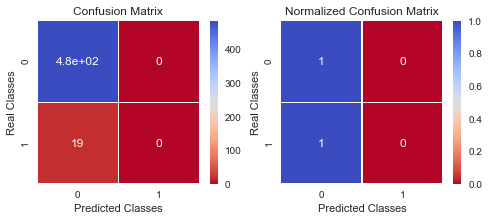

---Classification Report---
             precision    recall  f1-score   support

          0       0.96      1.00      0.98       485
          1       0.00      0.00      0.00        19

avg / total       0.93      0.96      0.94       504

AUC score is 0.52300596853


/Users/zuochaozhao/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/zuochaozhao/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


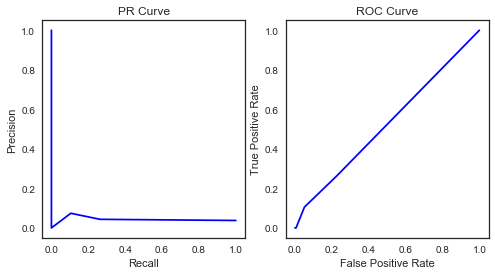


Logistic Regression :


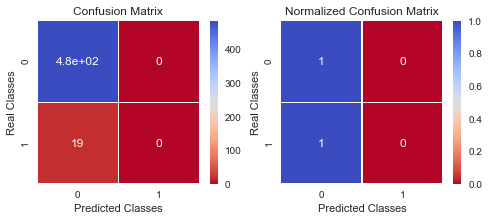

---Classification Report---
             precision    recall  f1-score   support

          0       0.96      1.00      0.98       485
          1       0.00      0.00      0.00        19

avg / total       0.93      0.96      0.94       504

AUC score is 0.566142159523


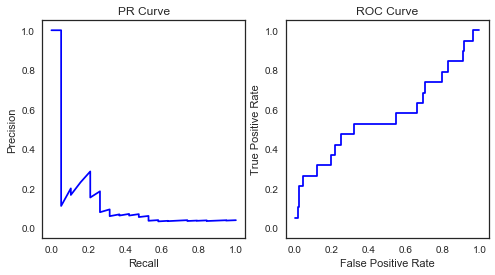


Gradient Booosting :


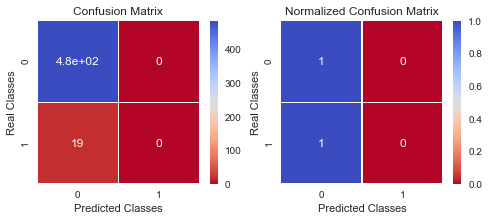

---Classification Report---
             precision    recall  f1-score   support

          0       0.96      1.00      0.98       485
          1       0.00      0.00      0.00        19

avg / total       0.93      0.96      0.94       504

AUC score is 0.477590884428


/Users/zuochaozhao/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/zuochaozhao/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


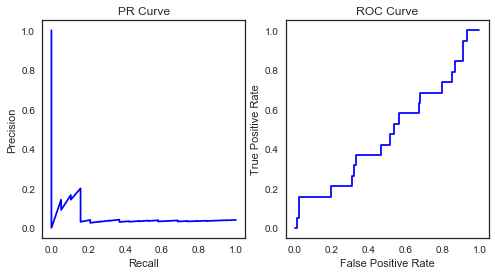


K-nearest neighbour :


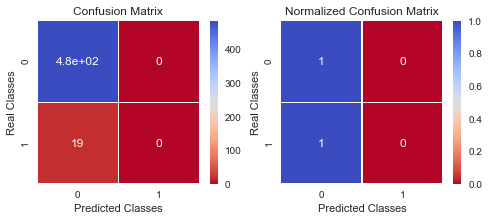

---Classification Report---
             precision    recall  f1-score   support

          0       0.96      1.00      0.98       485
          1       0.00      0.00      0.00        19

avg / total       0.93      0.96      0.94       504

AUC score is 0.491264243082


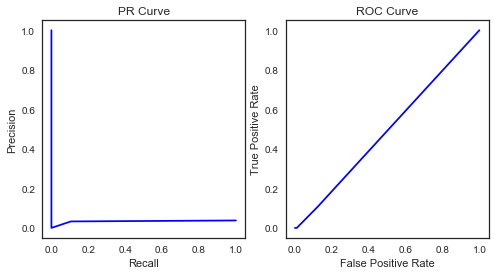

In [154]:
for name, model in models:
    print (name,':')
    predict_evaluation(model, X_train, y_train, X_test, y_test)
    print ()

#### 5.2 Over sampling

Random Forest :


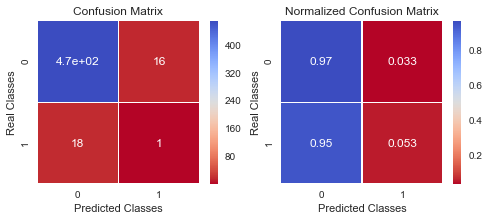

---Classification Report---
             precision    recall  f1-score   support

          0       0.96      0.97      0.97       485
          1       0.06      0.05      0.06        19

avg / total       0.93      0.93      0.93       504

AUC score is 0.51465002713


/Users/zuochaozhao/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


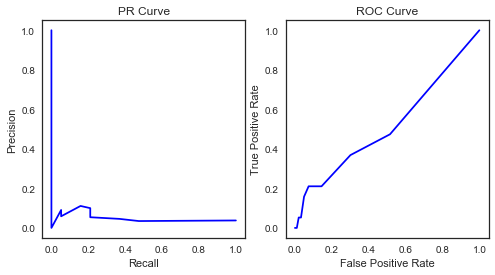


Logistic Regression :


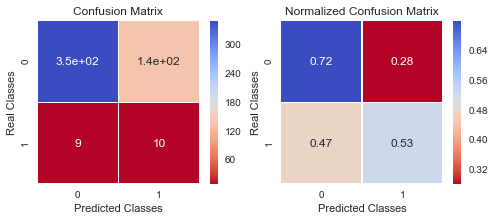

---Classification Report---
             precision    recall  f1-score   support

          0       0.97      0.72      0.83       485
          1       0.07      0.53      0.12        19

avg / total       0.94      0.71      0.80       504

AUC score is 0.592837764514


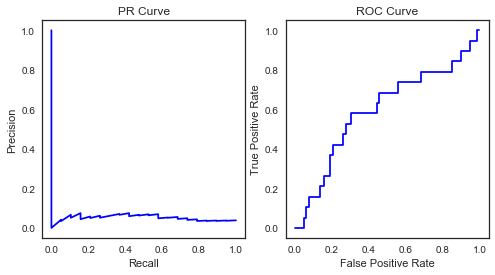


Gradient Booosting :


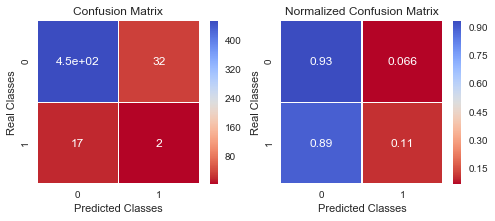

---Classification Report---
             precision    recall  f1-score   support

          0       0.96      0.93      0.95       485
          1       0.06      0.11      0.08        19

avg / total       0.93      0.90      0.92       504

AUC score is 0.516115029843


/Users/zuochaozhao/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


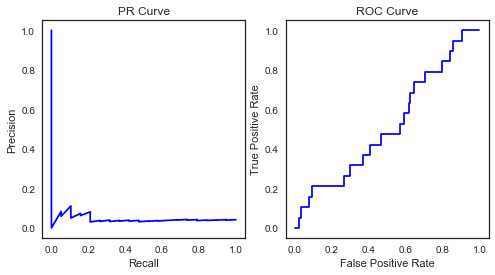


K-nearest neighbour :


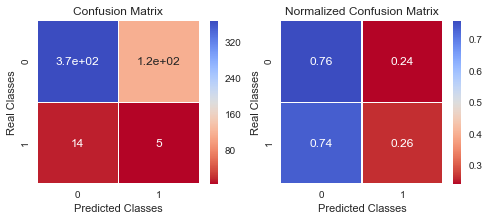

---Classification Report---
             precision    recall  f1-score   support

          0       0.96      0.76      0.85       485
          1       0.04      0.26      0.07        19

avg / total       0.93      0.74      0.82       504

AUC score is 0.507650569723


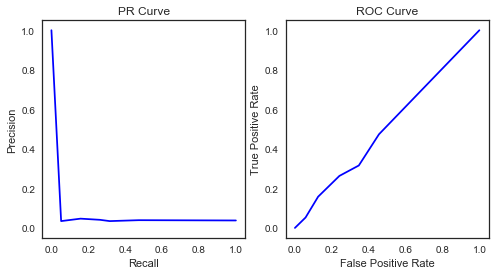

In [155]:
for name, model in models:
    print (name,':')
    predict_evaluation(model, os_X_train, os_y_train, X_test, y_test)
    print ()

#### 5.3 Under sampling

Random Forest :


/Users/zuochaozhao/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


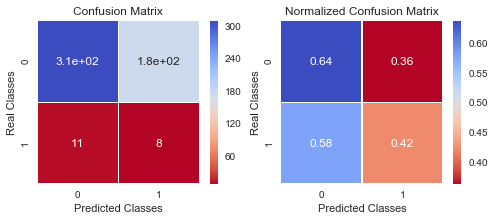

---Classification Report---
             precision    recall  f1-score   support

          0       0.97      0.64      0.77       485
          1       0.04      0.42      0.08        19

avg / total       0.93      0.63      0.74       504

AUC score is 0.582528486164


/Users/zuochaozhao/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


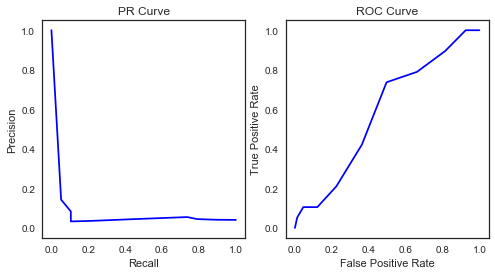


Logistic Regression :


/Users/zuochaozhao/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


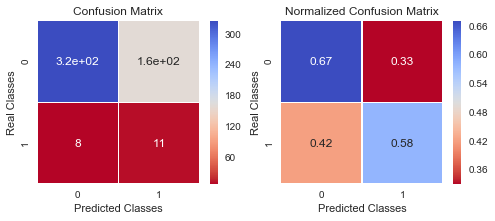

---Classification Report---
             precision    recall  f1-score   support

          0       0.98      0.67      0.79       485
          1       0.06      0.58      0.12        19

avg / total       0.94      0.67      0.77       504

AUC score is 0.53130765057


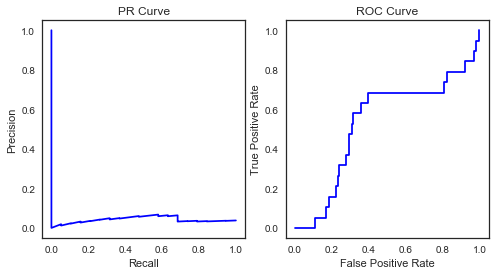


Gradient Booosting :


/Users/zuochaozhao/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/zuochaozhao/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


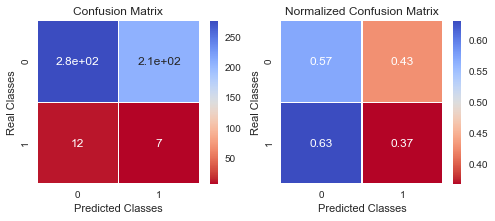

---Classification Report---
             precision    recall  f1-score   support

          0       0.96      0.57      0.72       485
          1       0.03      0.37      0.06        19

avg / total       0.92      0.56      0.69       504

AUC score is 0.525881714596


/Users/zuochaozhao/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


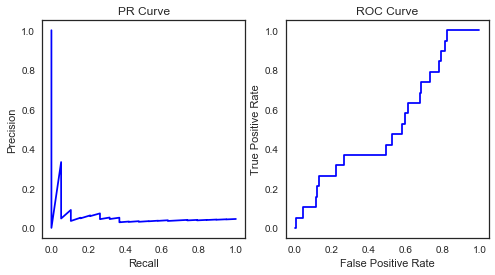


K-nearest neighbour :


/Users/zuochaozhao/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


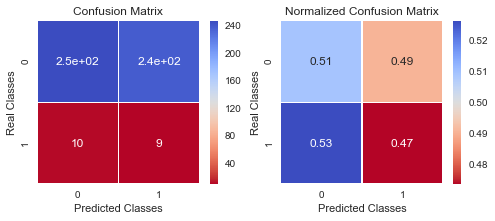

---Classification Report---
             precision    recall  f1-score   support

          0       0.96      0.51      0.67       485
          1       0.04      0.47      0.07        19

avg / total       0.93      0.51      0.64       504

AUC score is 0.447693977211


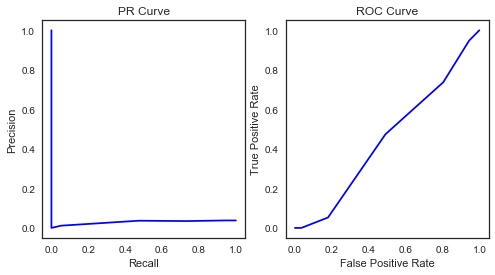

In [156]:
for name, model in models:
    print (name,':')
    predict_evaluation(model, us_X_train, us_y_train, X_test, y_test)
    print ()

Combine the results of part 4 and part 5, we find that oversampling performs better and Logistic Regression gives a better generalization. The tree methods have a strong learning in the training data set but suffer from overfitting. In the next section, we will focus on make an improvement on Logistic Regression first. 

### 6.Hyperparameter tuning 

#### 6.1 Grid search for LogisticRegression on oversampling data

In [164]:
parameters = {
    'C': np.linspace(1, 10, 10)
             }
model = LogisticRegression()
clf = GridSearchCV(model, parameters, cv=5, verbose=5, n_jobs=3)
clf.fit(os_X_train, os_y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] C=1.0 ...........................................................
[CV] C=1.0 ...........................................................
[CV] C=1.0 ...........................................................
[CV] .................. C=1.0, score=0.6879795396419437, total=   0.1s
[CV] C=1.0 ...........................................................
[CV] .............................. C=1.0, score=0.6875, total=   0.2s
[CV] C=1.0 ...........................................................
[CV] .................. C=1.0, score=0.7040816326530612, total=   0.2s
[CV] C=2.0 ...........................................................
[CV] .................. C=1.0, score=0.7148337595907929, total=   0.1s
[CV] C=2.0 ...........................................................
[CV] .............................. C=2.0, score=0.6875, total=   0.2s
[CV] C=2.0 ...........................................................
[CV] ...........

[Parallel(n_jobs=3)]: Done  18 tasks      | elapsed:    1.4s


[CV] .................. C=4.0, score=0.7058823529411765, total=   0.3s
[CV] C=4.0 ...........................................................
[CV] .................. C=5.0, score=0.7071611253196931, total=   0.2s
[CV] C=5.0 ...........................................................
[CV] .................. C=5.0, score=0.7002551020408163, total=   0.2s
[CV] C=6.0 ...........................................................
[CV] ................... C=4.0, score=0.710997442455243, total=   0.2s
[CV] C=6.0 ...........................................................
[CV] .................. C=5.0, score=0.7046035805626598, total=   0.2s
[CV] C=6.0 ...........................................................
[CV] .................. C=6.0, score=0.7028061224489796, total=   0.2s
[CV] C=6.0 ...........................................................
[CV] .................. C=6.0, score=0.7071611253196931, total=   0.2s
[CV] C=6.0 ...........................................................
[CV] .

[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    3.6s finished


In [165]:
clf.best_params_

{'C': 2.0}

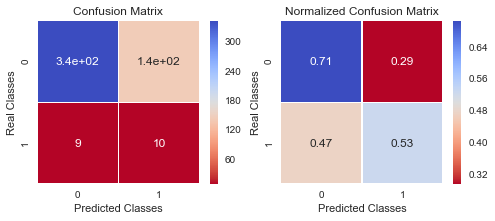

---Classification Report---
             precision    recall  f1-score   support

          0       0.97      0.71      0.82       485
          1       0.07      0.53      0.12        19

avg / total       0.94      0.70      0.79       504

AUC score is 0.589907759088


/Users/zuochaozhao/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


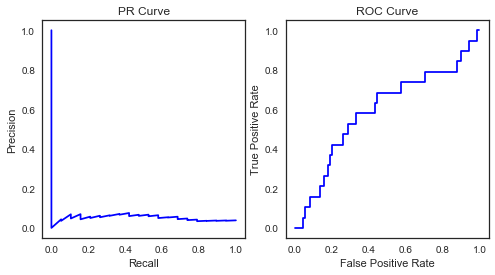

In [163]:
model = LogisticRegression(C=2.0)
predict_evaluation(model, os_X_train, os_y_train, X_test, y_test)

### 7 Change the Cutoff/Threshold values in evaluation metrics

#### 7.1 Different Cutoff/Threshold values in ROC metric on oversampling data

Recall metric in the testing dataset:  0.894736842105


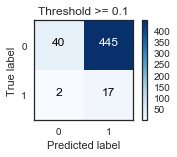

Recall metric in the testing dataset:  0.789473684211


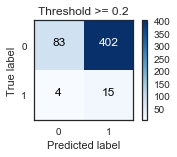

Recall metric in the testing dataset:  0.736842105263


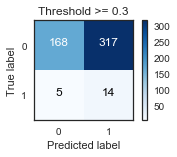

Recall metric in the testing dataset:  0.684210526316


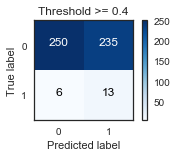

Recall metric in the testing dataset:  0.526315789474


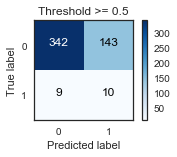

Recall metric in the testing dataset:  0.263157894737


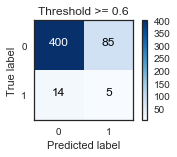

Recall metric in the testing dataset:  0.157894736842


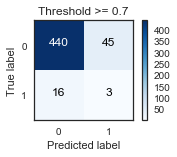

Recall metric in the testing dataset:  0.0


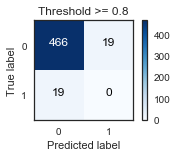

Recall metric in the testing dataset:  0.0


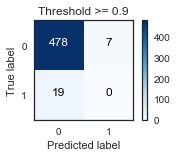

In [137]:
# Set up model and training data set
model = LogisticRegression(C=2.0)
model.fit(os_X_train ,os_y_train)
y_preds = model.predict_proba(X_test)

#Set up thresholds
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

#plt.figure(figsize=(10,10))

j = 1
for i in thresholds:
    
    #Change the thresholds
    y_test_predictions_high_recall = y_preds[:,1] > i
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test,y_test_predictions_high_recall)
    np.set_printoptions(precision=2)

    print("Recall metric in the testing dataset: ", cm[1,1]/(cm[1,0]+cm[1,1]))

    # Plot non-normalized confusion matrix
    plt.subplot(3,3,j)
    j += 1
    title='Threshold >= %s'%i
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    classes = [0,1]
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    

#### 7.2 Different Cutoff/Threshold values in Precision_Recall curves on oversampling data

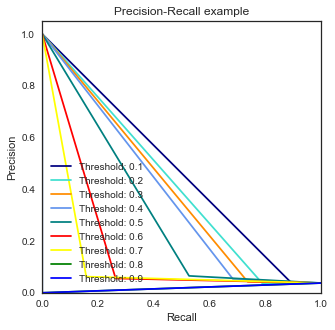

In [134]:
from itertools import cycle

# Set up model and training data set
model = LogisticRegression(C=2.0)
model.fit(os_X_train ,os_y_train)
y_preds = model.predict_proba(X_test)

#Set up thresholds
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'yellow', 'green', 'blue','black'])

plt.figure(figsize=(5,5))

j = 1
for i,color in zip(thresholds,colors):
    
    #Change the thresholds
    y_test_predictions_prob = y_preds[:,1] > i
    precision, recall, thresholds = precision_recall_curve(y_test,y_test_predictions_prob)
    
    # Plot Precision-Recall curve
    plt.plot(recall, precision, color=color,
                 label='Threshold: %s'%i)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall example')
    plt.legend(loc="lower left")
plt.show()